# Dendrogram
To illustrate the extent of clustering. E.g., Figure 2 of [this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.80.717&rep=rep1&type=pdf)  

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline
import torch
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

In [2]:
df = pd.read_csv("../notebooks/templated_stimuli.csv")
print(df.shape)
df.head()

(1600, 4)


,group,sentence,verb,construction
0,0,Bill tore the wall.,tore,transitive
1,0,Frank punched the door.,punched,transitive
2,0,Jack hit the fridge.,hit,transitive
3,0,Steve pulled the window.,pulled,transitive
4,0,Adam tore George the bread.,tore,ditransitive


In [3]:
modelname = "bert-base-cased"
encoder = AutoModel.from_pretrained(modelname)
tokenizer = AutoTokenizer.from_pretrained(modelname)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def batch_encode(df, encoder, tokenizer, cache_fname):
    bsz = 16
    result = []
    for i in tqdm(range(0, len(df), bsz)):
        batch_text = df["sentence"][i:i+bsz].tolist()
        batch_inputs = tokenizer(batch_text, truncation=True, 
                                 max_length=tokenizer.model_max_length,
                                 padding=True,
                                return_tensors="pt")
        with torch.no_grad():
            batch_output = encoder(**batch_inputs).pooler_output.numpy()  # (bsz, D)
            result.append(batch_output)
    res = np.concatenate(result, axis=0)
    torch.save(res, cache_fname)

#batch_encode(df, encoder, tokenizer, "../notebooks/templated_stimuli_bert.pkl")
#batch_encode(df, encoder, tokenizer, "../notebooks/templated_stimuli_roberta.pkl")

In [5]:
#encoded = torch.load("../notebooks/templated_stimuli_roberta.pkl")
encoded = torch.load("../notebooks/templated_stimuli_bert.pkl")
encoded.shape

(1600, 768)

In [6]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(encoded)

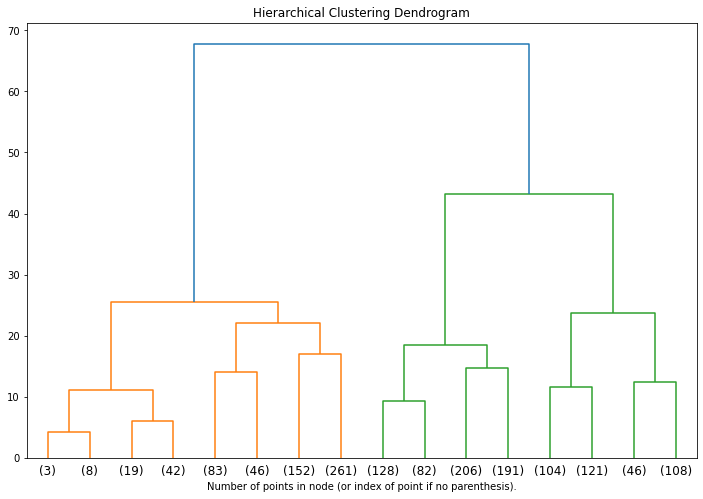

In [7]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

fig = plt.figure(figsize=(12,8))
plot_dendrogram(model, truncate_mode="level", p=3, orientation="top")
# Plot up to p+1 splits (2^{p+1} groups in total).
# If we cut 4 classes (p=1), are they going to be verb or construct?
# Looking from the numbers, the answer is "neither"...
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

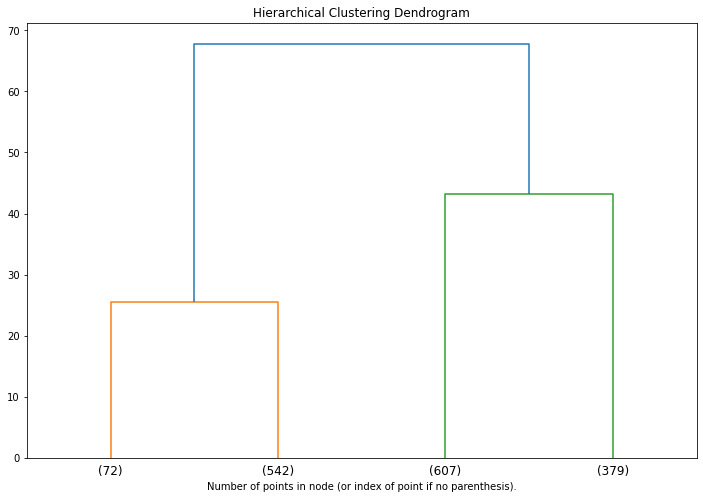

In [8]:
fig = plt.figure(figsize=(12,8))
plot_dendrogram(model, truncate_mode="level", p=1, orientation="top")
# Plot up to p+1 splits (2^{p+1} groups in total).
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [9]:
# Can I find which sentence goes into which branch?
cluster = AgglomerativeClustering(n_clusters=4)
labels = cluster.fit_predict(encoded)

In [10]:
df[f"{modelname}_cluster_outof4"] = labels    

In [11]:
for c in df[f"{modelname}_cluster_outof4"].drop_duplicates():
    df_c = df[df[f"{modelname}_cluster_outof4"] == c]
    verb_ns = df_c.groupby(["verb"]).count()["sentence"].tolist()
    print ("Group {} (total {}): N. of verbs: {}".format(c, len(df_c), verb_ns))

Group 1 (total 542): N. of verbs: [80, 77, 68, 20, 26, 28, 10, 62, 22, 149]
Group 2 (total 607): N. of verbs: [41, 45, 37, 57, 62, 112, 74, 114, 59, 6]
Group 0 (total 379): N. of verbs: [4, 6, 67, 52, 54, 52, 72, 14, 58]
Group 3 (total 72): N. of verbs: [15, 20, 4, 19, 6, 6, 1, 1]


In [12]:
for c in df[f"{modelname}_cluster_outof4"].drop_duplicates():
    df_c = df[df[f"{modelname}_cluster_outof4"] == c]
    construct_ns = df_c.groupby(["construction"]).count()["sentence"].tolist()
    print ("Group {} (total {}): N. of constructs: {}".format(c, len(df_c), construct_ns))

Group 1 (total 542): N. of constructs: [138, 131, 112, 161]
Group 2 (total 607): N. of constructs: [191, 78, 169, 169]
Group 0 (total 379): N. of constructs: [63, 158, 106, 52]
Group 3 (total 72): N. of constructs: [8, 33, 13, 18]


**Interpretations**  
These constructions spread across the 4 groups really equally. This indicates that when we cluster into 4 groups, they are mainly divided by something other than constructions.  
Update: Same applies to bert-base-cased.  

In [13]:
# Among each of these 4 groups, if we further split into 4, 
# are there imbalanaces among constructions?

cluster = AgglomerativeClustering(n_clusters=16)
labels = cluster.fit_predict(encoded)
df[f"{modelname}_cluster_outof16"] = labels

In [14]:
df.head()

,group,sentence,verb,construction,bert-base-cased_cluster_outof4,bert-base-cased_cluster_outof16
0,0,Bill tore the wall.,tore,transitive,1,4
1,0,Frank punched the door.,punched,transitive,2,1
2,0,Jack hit the fridge.,hit,transitive,0,0
3,0,Steve pulled the window.,pulled,transitive,0,11
4,0,Adam tore George the bread.,tore,ditransitive,1,6


In [16]:
for c in df[f"{modelname}_cluster_outof16"].drop_duplicates():
    df_c = df[df[f"{modelname}_cluster_outof16"]==c]
    const_counts = df_c.groupby(["construction"]).count()["sentence"].tolist()
    print("Cluster {} (total {}). N. of constructions: {}".format(
        c, len(df_c), const_counts
    ))

Cluster 4 (total 118). N. of constructions: [33, 18, 27, 40]
Cluster 1 (total 206). N. of constructions: [50, 3, 74, 79]
Cluster 0 (total 121). N. of constructions: [4, 83, 17, 17]
Cluster 11 (total 46). N. of constructions: [7, 15, 18, 6]
Cluster 6 (total 46). N. of constructions: [12, 25, 9]
Cluster 7 (total 108). N. of constructions: [24, 59, 21, 4]
Cluster 2 (total 210). N. of constructions: [111, 74, 4, 21]
Cluster 5 (total 191). N. of constructions: [30, 1, 91, 69]
Cluster 12 (total 104). N. of constructions: [28, 1, 50, 25]
Cluster 3 (total 61). N. of constructions: [2, 4, 35, 20]
Cluster 15 (total 113). N. of constructions: [29, 35, 7, 42]
Cluster 9 (total 83). N. of constructions: [4, 12, 35, 32]
Cluster 10 (total 87). N. of constructions: [41, 20, 8, 18]
Cluster 8 (total 61). N. of constructions: [8, 28, 9, 16]
Cluster 13 (total 34). N. of constructions: [17, 17]
Cluster 14 (total 11). N. of constructions: [5, 4, 2]


There are still fairly scattered distributions.  
Apparently, when we divide into 16 clusters, RoBERTa (update: BERT as well) still cluster by considering a lot of thing outside constructions